# LONG SHORT TERM MEMORY (LSTM)

LSTM is a special type of Recurrent Neural Network (RNN). RNN (Recurrent Neural Networks) struggle with long-term dependencies. 
This means they forget important details when dealing with long sequences. LSTMs solve this problem by remembering information for long periods.
LSTM has a special structure called memory cells with three gates that control the flow of information:

Forget Gate – Decides what information to forget from previous steps.

Input Gate – Decides what new information to add to the memory.

Output Gate – Decides what information to pass to the next step.

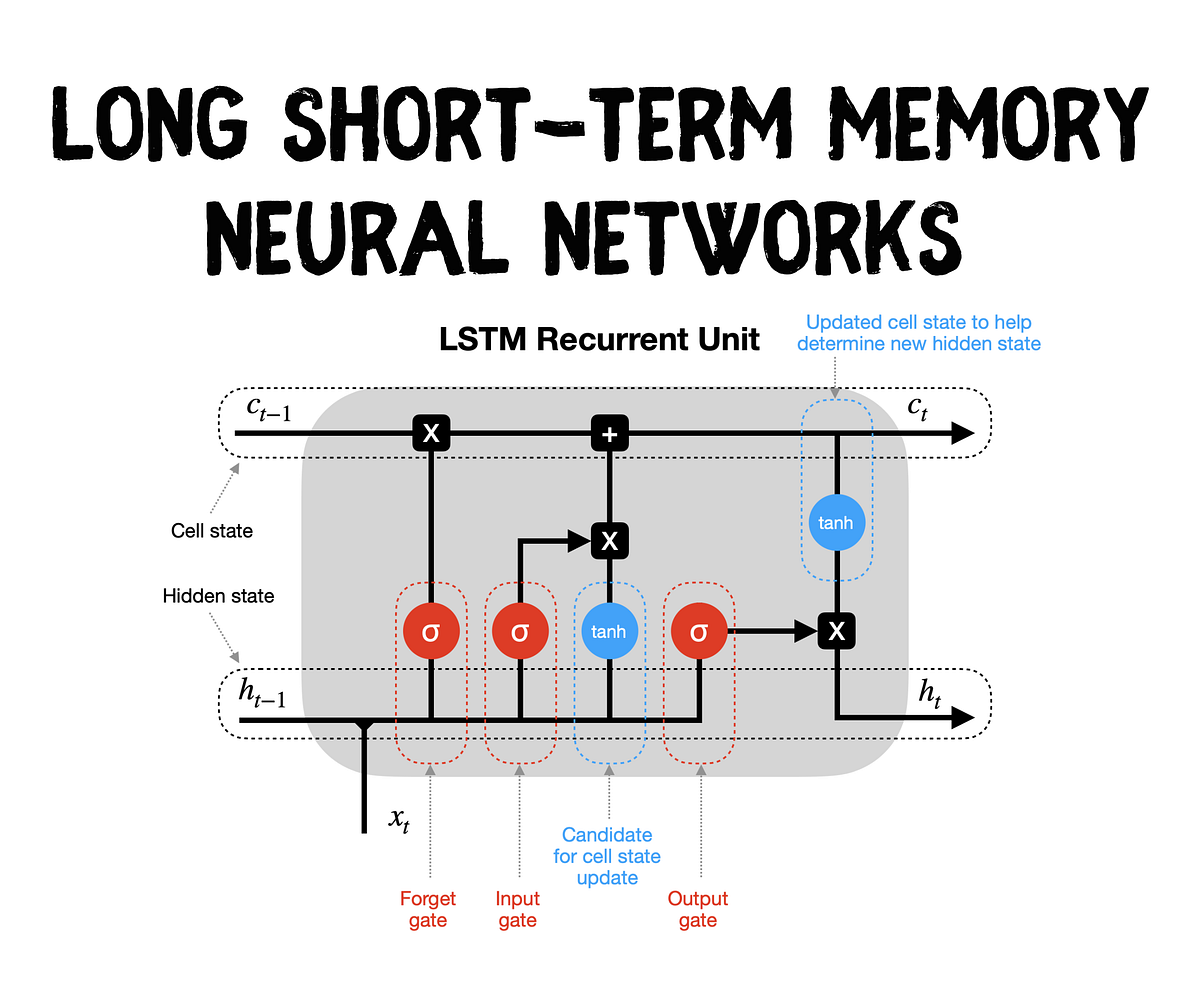
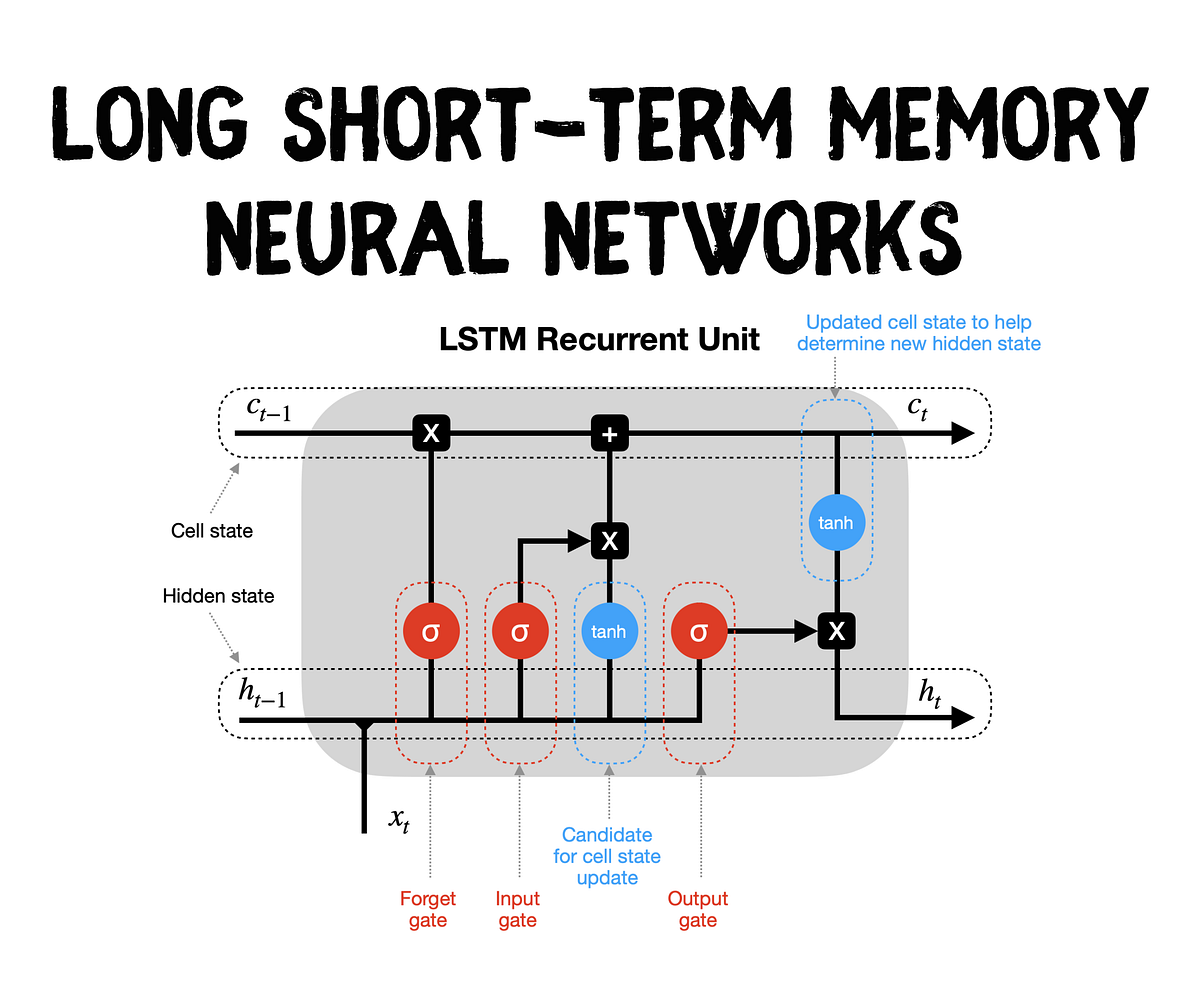

# IMPORTING LIBRARIES

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# LOADING DATASET

In [6]:
# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')


# DATA PREPROCESSING

# 1.  HANDLING MISSING VALUES 

In [7]:
# Drop irrelevant columns and handle missing values
df.drop(columns=['Date', 'Location'], inplace=True)
df.dropna(inplace=True)


# 2.  ENCODING

In [8]:
# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# 3. NORMALIZATION

In [9]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# APPLYING PCA

In [10]:
# 🔹 Apply PCA (Keep 95% Variance)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)


# SMOTE

In [11]:
# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Reshape input for LSTM (samples, timesteps, features)
X_reshaped = X_resampled.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])


# SPLIT TRAIN AND TEST 

In [12]:

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


# MODEL BUILDING

In [13]:
# 🔹 Build Optimized LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_pca.shape[1])),
    Dropout(0.3),  # Prevent overfitting
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# TRAINING MODEL BEFORE FEATURE SELECTION

In [14]:
# Train model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Predictions
y_pred_prob = model.predict(X_test).ravel()

# 🔹 Adjust threshold to improve recall
threshold = 0.4  
y_pred = (y_pred_prob > threshold).astype(int)

Epoch 1/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7903 - loss: 0.4613 - val_accuracy: 0.8011 - val_loss: 0.4204
Epoch 2/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7931 - loss: 0.4309 - val_accuracy: 0.8041 - val_loss: 0.4175
Epoch 3/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7986 - loss: 0.4227 - val_accuracy: 0.8073 - val_loss: 0.4145
Epoch 4/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8053 - loss: 0.4154 - val_accuracy: 0.8069 - val_loss: 0.4122
Epoch 5/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8024 - loss: 0.4172 - val_accuracy: 0.8078 - val_loss: 0.4106
Epoch 6/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8037 - loss: 0.4157 - val_accuracy: 0.8117 - val_loss: 0.4057
Epoch 7/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8088 - loss: 0.4094 - val_accuracy: 0.8141 - val_loss: 0.4031
Epoch 8/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8081 - loss: 0

# EVALUATING MODEL BEFORE FEATURE SELECTION

Accuracy: 0.8323
Precision: 0.7507
Recall: 0.8873
F1-Score: 0.8133
G-Mean: 0.8161
ROC AUC: 0.9186


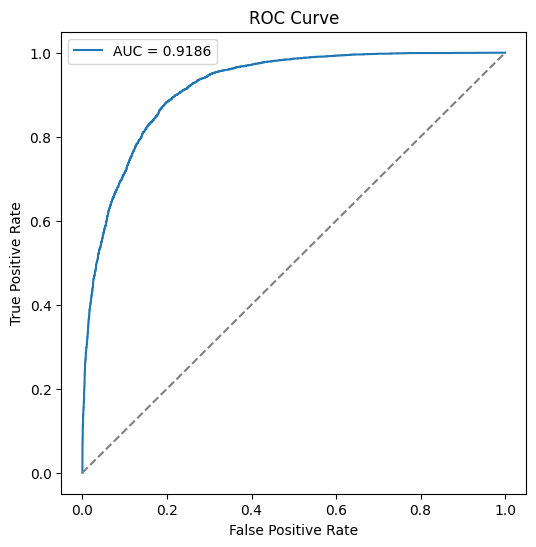

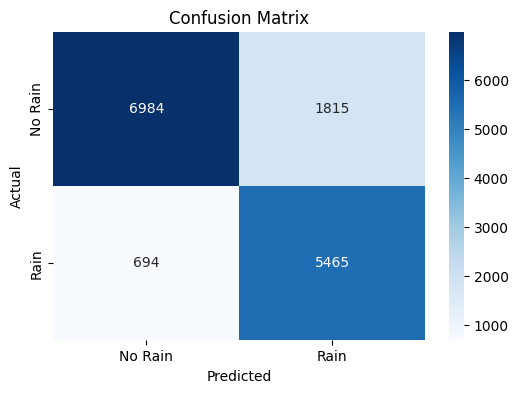

In [15]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
gmean = np.sqrt(recall * precision)
roc = roc_auc_score(y_test, y_pred_prob)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'G-Mean: {gmean:.4f}')
print(f'ROC AUC: {roc:.4f}')

# 🔹 Plot ROC Curve
plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# FEATURE SELECTION

In [16]:
# 🔹 SelectKBest Feature Selection (Select Top 16 Features)
selector = SelectKBest(score_func=f_classif, k=16)
X_selected = selector.fit_transform(X_scaled, y)


# SMOTE

In [17]:
# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Reshape input for LSTM (samples, timesteps, features)
X_reshaped = X_resampled.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])


# SPLITTING TRAIN AND TEST

In [18]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


# BUILD MODEL AFTER FEATURE SELECTION

In [19]:
# 🔹 Build Optimized LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_selected.shape[1])),
    Dropout(0.3),  # Prevent overfitting
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# TRAINING MODEL AFTER FEATURE SELECTION

In [20]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Predictions
y_pred_prob = model.predict(X_test).ravel()

# 🔹 Adjust threshold to improve recall
threshold = 0.4  
y_pred = (y_pred_prob > threshold).astype(int)

Epoch 1/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7917 - loss: 0.4468 - val_accuracy: 0.8121 - val_loss: 0.3985
Epoch 2/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8096 - loss: 0.4062 - val_accuracy: 0.8161 - val_loss: 0.3948
Epoch 3/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8132 - loss: 0.4009 - val_accuracy: 0.8165 - val_loss: 0.3907
Epoch 4/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8135 - loss: 0.3990 - val_accuracy: 0.8179 - val_loss: 0.3919
Epoch 5/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8114 - loss: 0.4011 - val_accuracy: 0.8211 - val_loss: 0.3882
Epoch 6/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8188 - loss: 0.3930 - val_accuracy: 0.8191 - val_loss: 0.3926
Epoch 7/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8187 - loss: 0.3915 - val_accuracy: 0.8224 - val_loss: 0.3866
Epoch 8/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8189 - loss: 0

# EVALUATING MODEL AFTER FEATURE SELECTION

Accuracy: 0.8374
Precision: 0.7690
Recall: 0.8649
F1-Score: 0.8142
G-Mean: 0.8156
ROC AUC: 0.9231


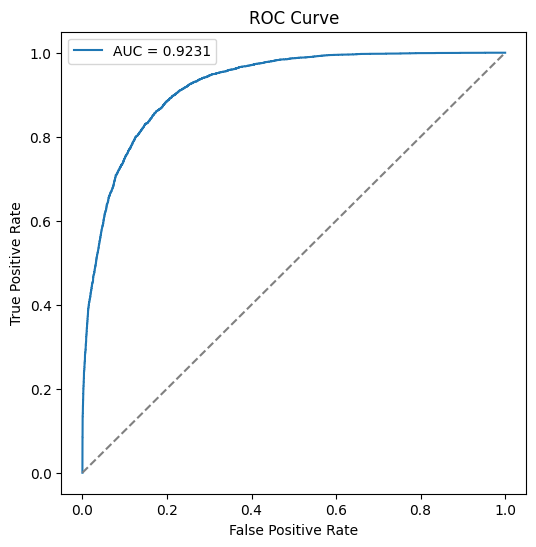

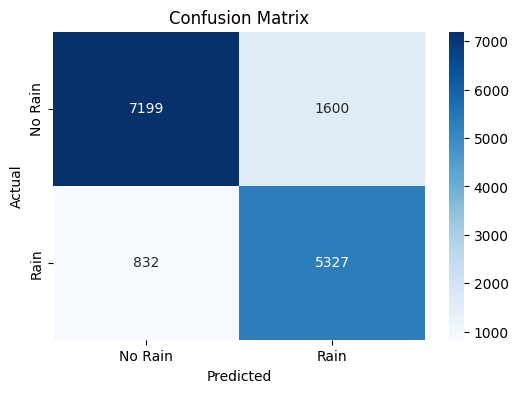

In [21]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
gmean = np.sqrt(recall * precision)
roc = roc_auc_score(y_test, y_pred_prob)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'G-Mean: {gmean:.4f}')
print(f'ROC AUC: {roc:.4f}')

# 🔹 Plot ROC Curve
plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1870/1870 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7846 - loss: 0.4668 - val_accuracy: 0.8002 - val_loss: 0.4239
Epoch 2/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7958 - loss: 0.4299 - val_accuracy: 0.8022 - val_loss: 0.4169
Epoch 3/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7963 - loss: 0.4243 - val_accuracy: 0.8034 - val_loss: 0.4154
Epoch 4/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8023 - loss: 0.4160 - val_accuracy: 0.8063 - val_loss: 0.4117
Epoch 5/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8026 - loss: 0.4153 - val_accuracy: 0.8097 - val_loss: 0.4091
Epoch 6/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8047 - loss: 0.4155 - val_accuracy: 0.8097 - val_loss: 0.4083
Epoch 7/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8078 - loss: 0.4072 - val_accuracy: 0.8127 - val_loss: 0.4041
Epoch 8/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8079 - loss: 0.4068 - val

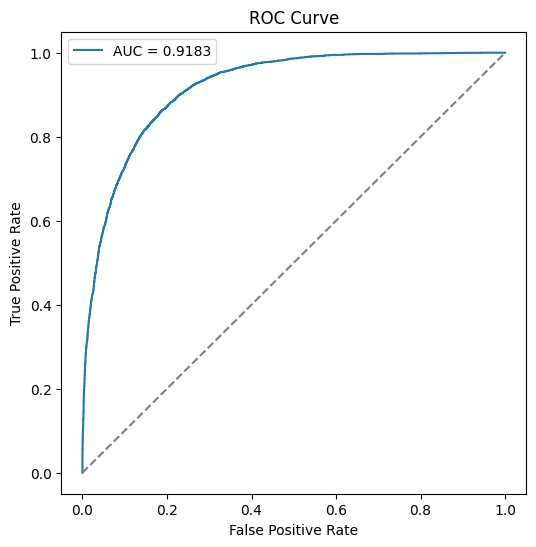

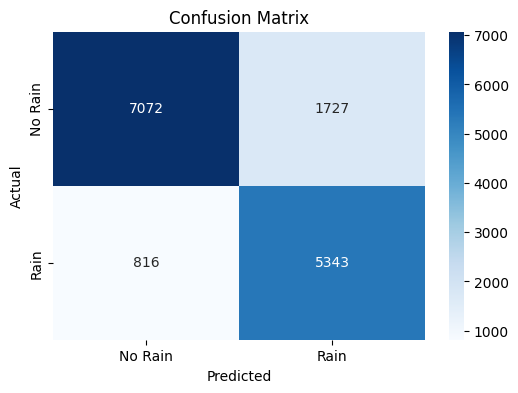

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')

# Drop irrelevant columns and handle missing values
df.drop(columns=['Date', 'Location'], inplace=True)
df.dropna(inplace=True)

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Apply PCA (Keep 95% Variance)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Reshape input for LSTM (samples, timesteps, features)
X_reshaped = X_resampled.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# 🔹 Build Optimized LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_pca.shape[1])),
    Dropout(0.3),  # Prevent overfitting
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Predictions
y_pred_prob = model.predict(X_test).ravel()

# 🔹 Adjust threshold to improve recall
threshold = 0.4  
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
gmean = np.sqrt(recall * precision)
roc = roc_auc_score(y_test, y_pred_prob)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'G-Mean: {gmean:.4f}')
print(f'ROC AUC: {roc:.4f}')

# 🔹 Plot ROC Curve
plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1870/1870 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7886 - loss: 0.4529 - val_accuracy: 0.8129 - val_loss: 0.3998
Epoch 2/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8121 - loss: 0.4048 - val_accuracy: 0.8135 - val_loss: 0.3996
Epoch 3/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8132 - loss: 0.3985 - val_accuracy: 0.8160 - val_loss: 0.3938
Epoch 4/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8132 - loss: 0.4013 - val_accuracy: 0.8188 - val_loss: 0.3904
Epoch 5/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8159 - loss: 0.3974 - val_accuracy: 0.8208 - val_loss: 0.3912
Epoch 6/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8180 - loss: 0.3947 - val_accuracy: 0.8224 - val_loss: 0.3842
Epoch 7/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8161 - loss: 0.3932 - val_accuracy: 0.8217 - val_loss: 0.3835
Epoch 8/50
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8200 - loss: 0.3877 - val

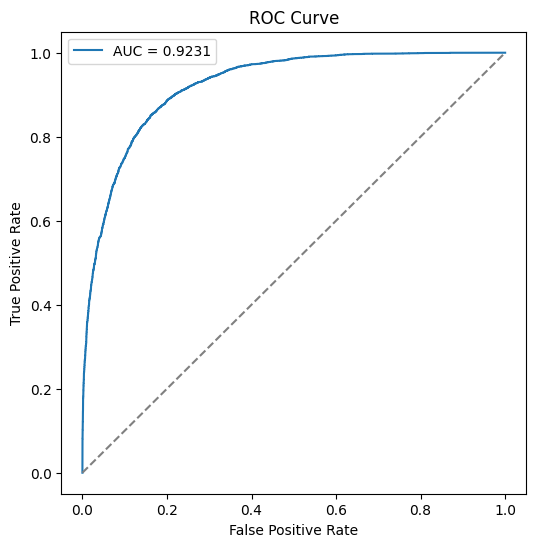

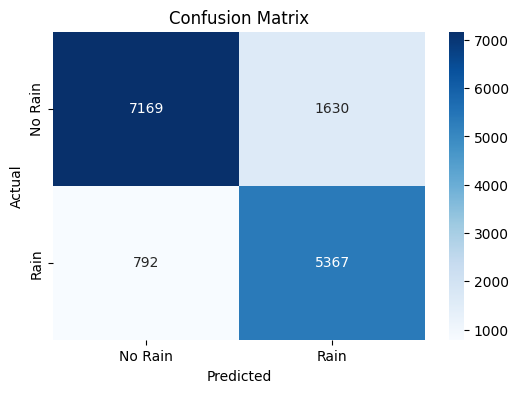

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv('/kaggle/input/weather-australia/weatherAUS.csv')

# Drop irrelevant columns and handle missing values
df.drop(columns=['Date', 'Location'], inplace=True)
df.dropna(inplace=True)

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features and target
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 SelectKBest Feature Selection (Select Top 16 Features)
selector = SelectKBest(score_func=f_classif, k=16)
X_selected = selector.fit_transform(X_scaled, y)

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Reshape input for LSTM (samples, timesteps, features)
X_reshaped = X_resampled.reshape(X_resampled.shape[0], 1, X_resampled.shape[1])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# 🔹 Build Optimized LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_selected.shape[1])),
    Dropout(0.3),  # Prevent overfitting
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Predictions
y_pred_prob = model.predict(X_test).ravel()

# 🔹 Adjust threshold to improve recall
threshold = 0.4  
y_pred = (y_pred_prob > threshold).astype(int)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
gmean = np.sqrt(recall * precision)
roc = roc_auc_score(y_test, y_pred_prob)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'G-Mean: {gmean:.4f}')
print(f'ROC AUC: {roc:.4f}')

# 🔹 Plot ROC Curve
plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
